In [1]:
import os
import datetime
from astropy import units as u

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

import pandas as pd
pd.set_option("display.max_columns", None)

ZMAG = 25.0
ITIME = 60.0 * u.second

DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data/Iturbide Aviles"

In [2]:
df = pd.DataFrame()
for dataFile in [f for f in os.listdir(DATA_DIR) if '.dat' in f]:
    data = pd.read_csv(os.path.join(DATA_DIR, dataFile), sep='\t', names=['julianDate', 'mag', 'unknown'])
    data.drop(columns=['unknown'], inplace=True)
    data['julianDate'] += 2459000
    df = pd.concat([df, data], ignore_index=True)

df.sort_values(by=['julianDate'], ignore_index=True, inplace=True)
df

,julianDate,mag
0,2.459876e+06,17.040
1,2.459876e+06,17.123
2,2.459876e+06,17.142
3,2.459876e+06,17.221
4,2.459876e+06,17.060
...,...,...
545,2.459890e+06,17.308
546,2.459890e+06,17.286
547,2.459890e+06,17.387
548,2.459890e+06,17.318


In [3]:
import numpy as np

df['flux'] = ITIME * 10**((2/5)*(ZMAG - df['mag']))
# df['normFlux'] = df['flux'] / np.median(df['flux'])
df

,julianDate,mag,flux
0,2.459876e+06,17.040,91653.963494
1,2.459876e+06,17.123,84908.515976
2,2.459876e+06,17.142,83435.572528
3,2.459876e+06,17.221,77580.263508
4,2.459876e+06,17.060,89981.090130
...,...,...,...
545,2.459890e+06,17.308,71606.302753
546,2.459890e+06,17.286,73072.043093
547,2.459890e+06,17.387,66581.143606
548,2.459890e+06,17.318,70949.812223


In [4]:
from astropy.timeseries import TimeSeries
from astropy.time import Time

ZTF_PERIOD = 0.333566999 * u.day # obtained from IRSA periodogram

# TODO: confirm with Dr. Aviles about time scale; assuming UTC for now
ts = TimeSeries(time=Time(df['julianDate'], format='jd', scale='utc'), data={
	'mag': df['mag'],
	'flux': df['flux']
})
ts

time,mag,flux
Time,float64,float64
2459875.57101,17.04,91653.96349428449
2459875.57171,17.123,84908.51597588573
2459875.57241,17.142,83435.57252792676
2459875.57311,17.221,77580.26350777678
2459875.57381,17.06,89981.09013014253
2459875.57451,16.976,97219.02256440012
2459875.57521,16.979,96950.76725694016
2459875.57591,17.087,87771.0412199913
2459875.57661,17.286,73072.04309347547


In [8]:
from astropy.coordinates import EarthLocation, SkyCoord

atoCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
helioCorrection = ts.time.light_travel_time(atoCoord, kind='heliocentric', location=iturbideLocation)
hjd = ts.time + helioCorrection

# setting new time to HJD calculated above; have to do it in a new TimeSeries
ts = TimeSeries(time=hjd, data={
	'mag': ts['mag'],
	'flux': ts['flux']
})
ts

time,mag,flux
Time,float64,float64
2459875.574499226,17.04,91653.96349428449
2459875.5751992064,17.123,84908.51597588573
2459875.575899187,17.142,83435.57252792676
2459875.576599168,17.221,77580.26350777678
2459875.5772991483,17.06,89981.09013014253
2459875.577999129,16.976,97219.02256440012
2459875.578699109,16.979,96950.76725694016
2459875.5793990903,17.087,87771.0412199913
2459875.5800990704,17.286,73072.04309347547


In [9]:
foldedTs = ts.fold(period=ZTF_PERIOD, epoch_time=ts.time[np.argmin(ts['flux'])], normalize_phase=True)

In [10]:
def findClosestQuarterPhaseMag(foldedTs: TimeSeries) -> int:
	adjustedPhases = foldedTs.time.value + 0.5 # so that phases go 0 -> 1
	diff = np.abs(adjustedPhases - 0.75) # using 3/4 phase, since LC is missing coverage for 0.25 phase
	return foldedTs['mag'][np.argmin(diff)]

# converting magnitudes to fluxes; since these are differential magnitudes we can convert them to fluxes using the expression outlined in this comment:
	# https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476
quarterPhaseMag = findClosestQuarterPhaseMag(foldedTs)
ts['norm_flux'] = 10**(-(2/5) * (ts['mag'] - quarterPhaseMag))
foldedTs['norm_flux'] = 10**(-(2/5) * (foldedTs['mag'] - quarterPhaseMag))
ts

time,mag,flux,norm_flux
Time,float64,float64,float64
2459875.574499226,17.04,91653.96349428449,0.8847080928705314
2459875.5751992064,17.123,84908.51597588573,0.8195963204818452
2459875.575899187,17.142,83435.57252792676,0.805378441199067
2459875.576599168,17.221,77580.26350777678,0.7488589075216437
2459875.5772991483,17.06,89981.09013014253,0.868560350348778
2459875.577999129,16.976,97219.02256440012,0.9384259312370187
2459875.578699109,16.979,96950.76725694016,0.9358365435835307
2459875.5793990903,17.087,87771.0412199913,0.8472274141405967
2459875.5800990704,17.286,73072.04309347547,0.705342414258096


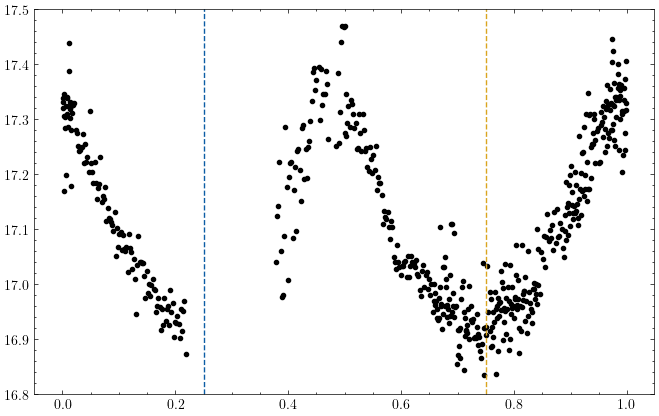

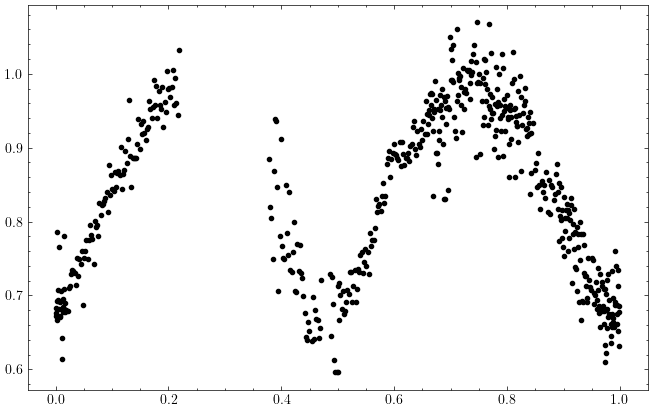

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(foldedTs.time.value + 0.5, foldedTs['mag'], marker='.', linestyle='none', color='black')
plt.vlines(0.25, 16.8, 17.5, linestyles='dashed')
plt.vlines(0.75, 16.8, 17.5, linestyles='dashed', color='goldenrod')
plt.ylim(16.8, 17.5)

plt.figure(figsize=(8, 5))
plt.plot(foldedTs.time.value + 0.5, foldedTs['norm_flux'], marker='.', linestyle='none', color='black')

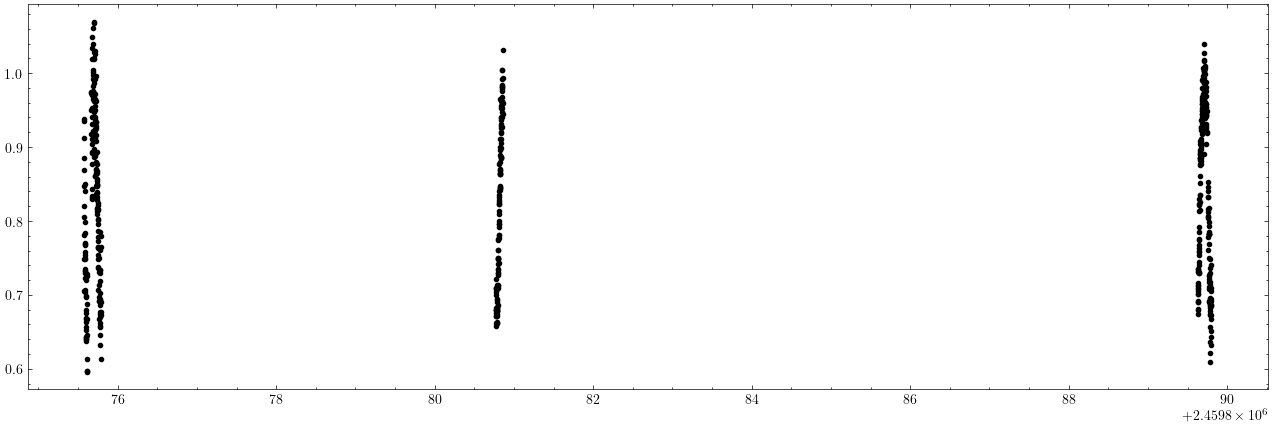

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(ts.time.value, ts['norm_flux'], marker='.', linestyle='none', color='black')

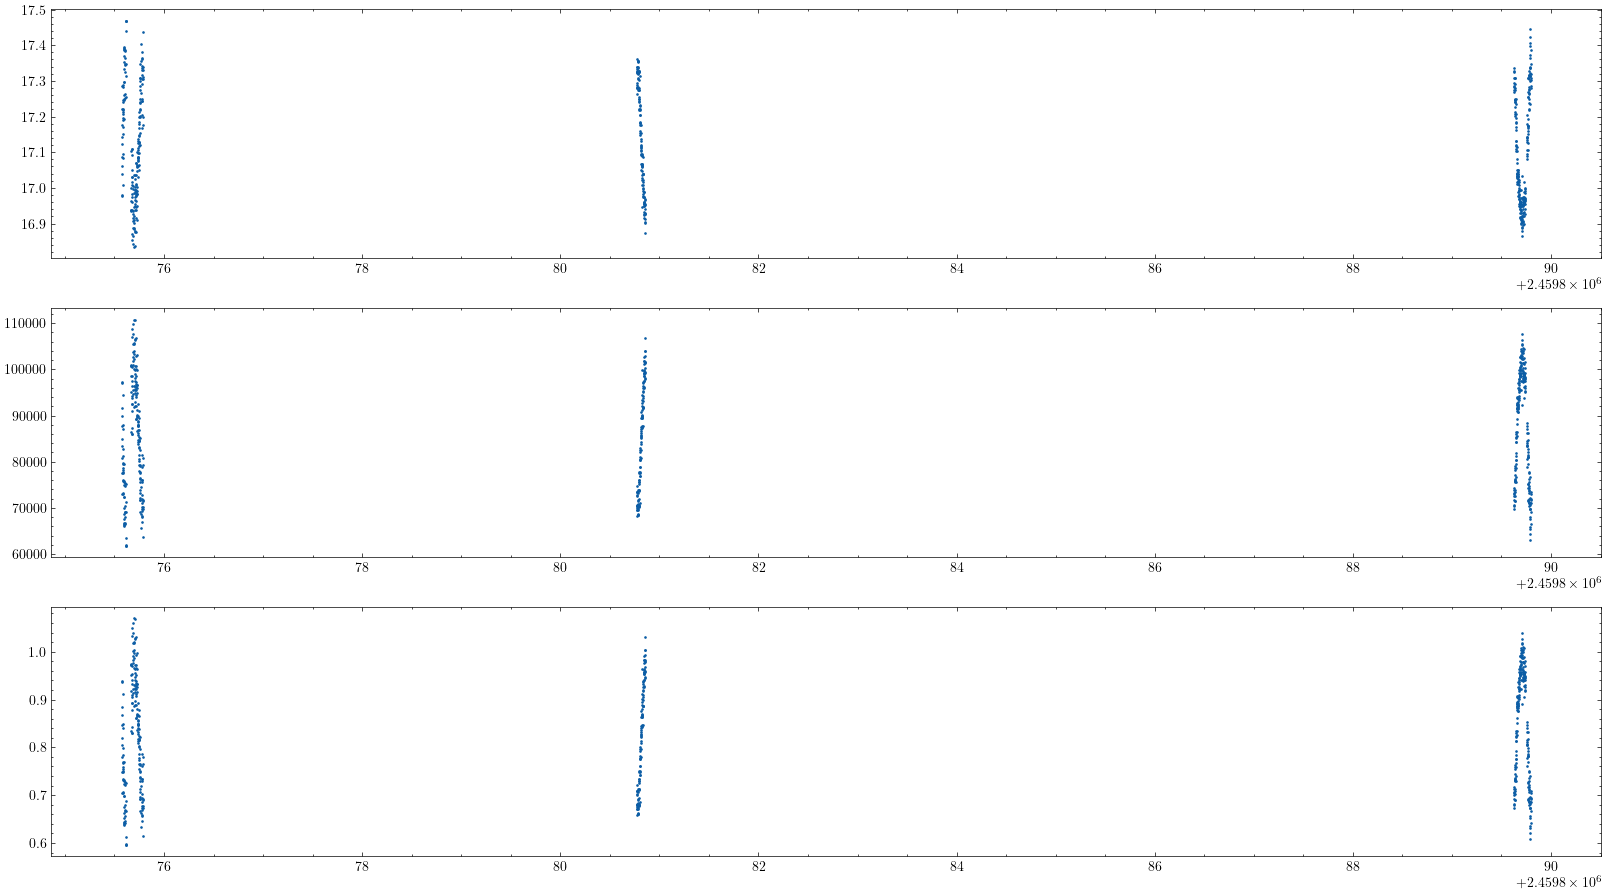

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(20, 11))
axs[0].scatter(ts.time.value, ts['mag'], s=0.8)
axs[1].scatter(ts.time.value, ts['flux'], s=0.8)
axs[2].scatter(ts.time.value, ts['norm_flux'], s=0.8)

In [15]:
# df.to_csv(os.path.join(DATA_DIR, "aviles-differential-flux.csv"), index=False)
ts.write(os.path.join(DATA_DIR, "normalized-differential-flux.ecsv"), overwrite=True)